## 0. Libarary 불러오기 및 경로설정

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms.functional import to_pil_image # tensor to pil_image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize

In [2]:
# 데이터셋 폴더 경로를 지정
train_dir = '../input/data/train'
test_dir = '../input/data/eval'

In [3]:
class TrainDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform # 그레이 변환
    
    def __getitem__(self, index):
        images = []
        root = self.img_paths[index]
        
        gender = root.split('_')[1]
        age = int(root.split('_')[3])
        
        masks = []
        for f in os.listdir(root):
            if f.startswith('mask') or f.startswith('normal') or f.startswith('incorrect'):
                image = Image.open(os.path.join(root, f))
                if self.transform:
                    image = self.transform(image)
                masks.append((f, image))
        return [(gender, age, mask, path) for mask, path in masks]
        
    def __len__(self):
        return len(self.data)

In [4]:
# meta 데이터와 이미지 경로를 불러옵니다.
train_meta = pd.read_csv(os.path.join(train_dir, 'train.csv'))
image_dir = os.path.join(train_dir, 'images')

# Train Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in train_meta.path]
transform = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
])
train_ds = TrainDataset(image_paths, transform)

loader = DataLoader(
    train_ds,
    shuffle=False
)

('female', 'female', 'female', 'female', 'female', 'female', 'female')
(56, 56, 56, 56, 56, 56, 56)


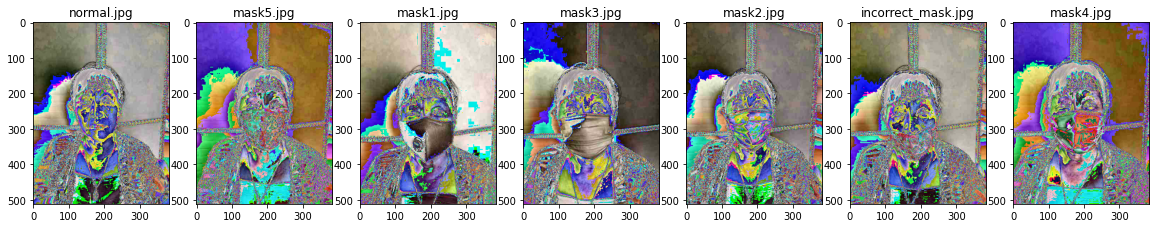

In [5]:
# 이미지 파일 테스트
# index에 해당하는 여러 개의 이미지 데이터가 존재
gender, age, mask, image = zip(*train_ds[7]) # gender, age, mask, image

print(gender)
print(age)
# print(mask)
# print(image)
i = 1
plt.figure(figsize=(20, 14))
for m, im in zip(mask, image):
    plt.subplot(1,len(mask),i)
    plt.imshow(to_pil_image(im))
    plt.title(m)
    i += 1
plt.show()

## 1. Model 정의

In [6]:
class MyModel(nn.Module):
    def __init__(self, num_classes: int = 1000):
        super(MyModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## 2. Test Dataset 정의

In [7]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

## 3. Inference

In [8]:
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
transform = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
])
dataset = TestDataset(image_paths, transform)

loader = DataLoader(
    dataset,
    shuffle=False
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
device = torch.device('cuda')
model = MyModel(num_classes=18).to(device)
model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')

test inference is done!
